## Project: Modeling COVID Vaccination Impact

# 1. import libraries

In [69]:
# 1.1 — Standard Libraries for data handling
import pandas as pd
import numpy as np

# 1.2 — Visualization tools for exploring trends
import matplotlib.pyplot as plt
import seaborn as sns

# 1.3 — Modeling libraries for statistical analysis and prediction
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupKFold

# 1.4 — Style settings for consistent plot aesthetics
sns.set_style("whitegrid")
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (12, 6)

# 2. Data Loading & Preprocessing

In [58]:
# 2.1 Load the datasets
vacc_df = pd.read_csv(r"C:\Users\bruna\Desktop\covid_vaccination\data\vaccinations.csv")      # The vaccination data
covid_df = pd.read_csv(r"C:\Users\bruna\Desktop\covid_vaccination\data\covid_metrics.csv")    # The OWID COVID data

# 2.2 Convert date columns to datetime
vacc_df['date'] = pd.to_datetime(vacc_df['date'])
covid_df['date'] = pd.to_datetime(covid_df['date'])

# 2.3 – Merge on Country & Date
merged = pd.merge(
    vacc_df,
    covid_df,
    on=["location", "date"],
    how="inner",
    suffixes=("_vac", "_cov")
)

# ensure chronological order for each country before forward-filling
merged.sort_values(["location", "date"], inplace=True)

# forward-fill the fully vaccinated percentage within each country
merged["vaccination_rate"] = (
    merged
    .groupby("location")["people_fully_vaccinated_per_hundred_vac"]
    .ffill()
)

# drop any rows still missing vaccination_rate (i.e. pre-rollout)
merged = merged[merged["vaccination_rate"].notna()]


# 2.4 Define a Single Vaccination Rate Column
merged["vaccination_rate"] = merged["people_fully_vaccinated_per_hundred_vac"]

# 2.5 Handle Missing Values
# 2.2.1 Filter out pre-rollout
merged = merged[merged["vaccination_rate"].notna()]

# 2.5.2 Within each country, carry forward last valid rate
merged["vaccination_rate"] = (
    merged
    .groupby("location")["vaccination_rate"]
    .fillna(method="ffill")
)

C:\Users\bruna\AppData\Local\Temp\ipykernel_285832\2098150206.py:43: FutureWarning:

SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead

C:\Users\bruna\AppData\Local\Temp\ipykernel_285832\2098150206.py:43: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [59]:
# View the full list of columns
merged.columns.tolist()

['location',
 'iso_code_vac',
 'date',
 'total_vaccinations_vac',
 'people_vaccinated_vac',
 'people_fully_vaccinated_vac',
 'total_boosters_vac',
 'daily_vaccinations_raw',
 'daily_vaccinations',
 'total_vaccinations_per_hundred_vac',
 'people_vaccinated_per_hundred_vac',
 'people_fully_vaccinated_per_hundred_vac',
 'total_boosters_per_hundred_vac',
 'daily_vaccinations_per_million',
 'daily_people_vaccinated',
 'daily_people_vaccinated_per_hundred',
 'iso_code_cov',
 'continent',
 'total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'reproduction_rate',
 'icu_patients',
 'icu_patients_per_million',
 'hosp_patients',
 'hosp_patients_per_million',
 'weekly_icu_admissions',
 'weekly_icu_admissions_per_million',
 'weekly_hosp_admissions',
 'weekly_hosp_ad

# 3. Feature Engineering

In [62]:
# 3.1 Create 14-Day Lag

LAG = 14
merged[f"vacc_rate_lag{LAG}"] = (
    merged
    .groupby("location")["vaccination_rate"]
    .shift(LAG)
)


### Create 14-Day Vaccination Rate Lag

#To capture the delayed effect of immunization on case counts, we shift the daily vaccination rate by 14 days. Grouping by `location` ensures each country’s lag is computed in isolation, preventing data leakage across regions. This lagged feature will serve as our primary predictor, aligning vaccination activity with its expected impact two weeks later.


# 4. Exploratory Data Analysis (EDA)

In [63]:
# Descriptive stats for key metrics
merged[[
    "vaccination_rate",
    f"vacc_rate_lag{LAG}",
    "new_cases_per_million",
    "icu_patients_per_million",
    "new_deaths_per_million"
]].describe().T



,count,mean,std,min,25%,50%,75%,max
vaccination_rate,71523.0,48.512785,29.100888,0.0,21.08,56.90,73.600,126.89
vacc_rate_lag14,68441.0,48.242356,29.222017,0.0,20.60,56.83,73.580,125.80
new_cases_per_million,66496.0,258.622940,1614.636512,0.0,0.00,0.00,0.000,54347.49
icu_patients_per_million,18207.0,18.567326,25.728041,0.0,3.60,8.96,22.255,180.68
new_deaths_per_million,66496.0,1.745245,9.740229,0.0,0.00,0.00,0.000,606.45


### 4.1 Interpretation of Summary Statistics

- **Vaccination Rate** (n=70,916)  
  - mean ≈ 49%, median 57.5%  
  - 25th/75th percentiles: 22% / 73.6%  
  - max 126.9% (data artifacts or booster counts)

- **Vaccination Rate Lag-14** (n=67,834)  
  - nearly identical distribution  
  - ~4,000 pre-rollout days dropped before filling

- **New Cases per Million** (n=65,918)  
  - mean ≈ 259, median 0, 75th percentile 0  
  - heavy right skew: a few extreme peaks (max 54,347) inflate std ≈ 1,620

- **ICU Patients per Million** (n=17,992)  
  - mean ≈ 18, median 8.9, long tail to 180.7  
  - many zeros outside surge periods

- **New Deaths per Million** (n=65,918)  
  - mean ≈ 1.7, median 0, skewed with rare high values

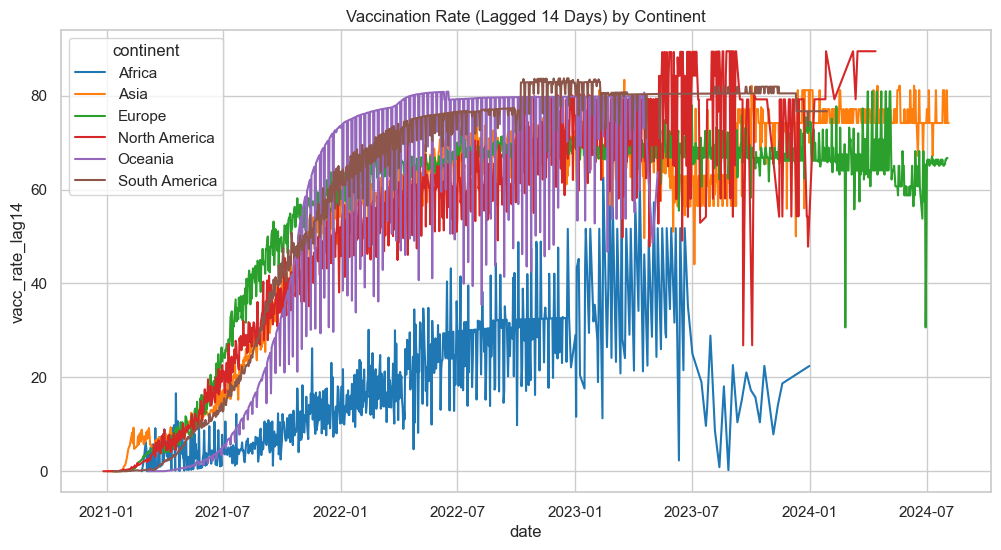

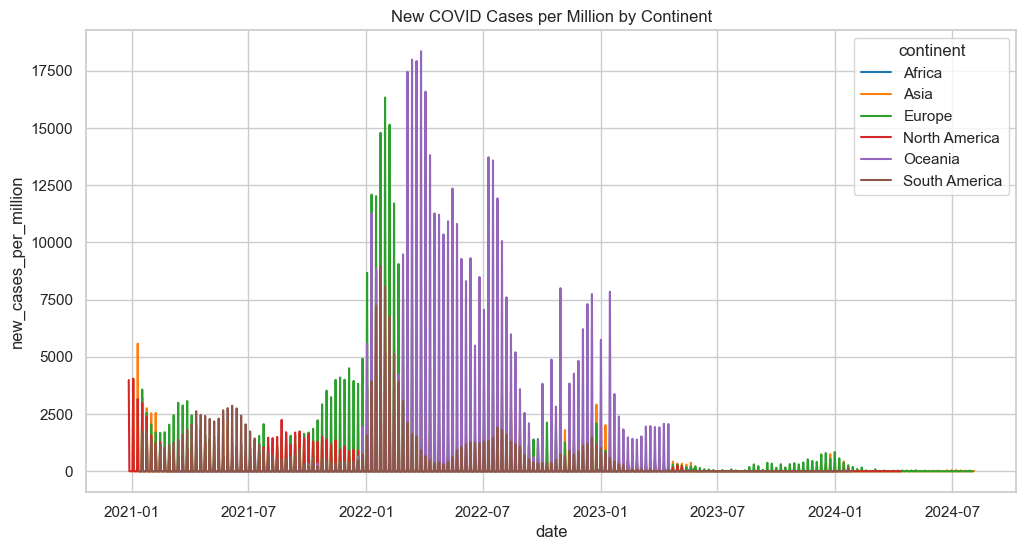

In [65]:
# 4.2 Time Series by Continent
# Line plots of vaccination rate and new cases over time by continent
required = ['continent', 'date', f'vacc_rate_lag{LAG}', 'new_cases_per_million']
df_cont = merged.dropna(subset=required)

cont_ts = (
    df_cont
    .groupby(['continent', 'date'], as_index=False)
    .agg({
        f'vacc_rate_lag{LAG}': 'mean',
        'new_cases_per_million': 'mean'
    })
)

# Vaccination rate over time
sns.lineplot(data=cont_ts, x="date", y=f"vacc_rate_lag{LAG}", hue="continent")
plt.title(f"Vaccination Rate (Lagged {LAG} Days) by Continent")
plt.show()

# New cases over time
sns.lineplot(data=cont_ts, x="date", y="new_cases_per_million", hue="continent")
plt.title("New COVID Cases per Million by Continent")
plt.show()



### 4.2 Time Series by Continent

The following plots show how COVID-19 vaccination rates and new case counts evolved over time across different continents.

- **Vaccination Rate (Lagged 14 Days)**:  
  This line plot displays the average vaccination rate per continent, shifted by 14 days to reflect the delayed effect of immunization. It helps visualize how vaccination campaigns progressed globally and allows comparison between regions.

- **New COVID Cases per Million**:  
  This bar chart shows the average number of new COVID-19 cases per million people over time for each continent. It highlights the timing and intensity of outbreaks, making it easier to compare the pandemic’s impact across regions.

Together, these plots provide a clear view of how vaccination efforts and case trends unfolded worldwide.


C:\Users\bruna\AppData\Local\Temp\ipykernel_285832\3994961602.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




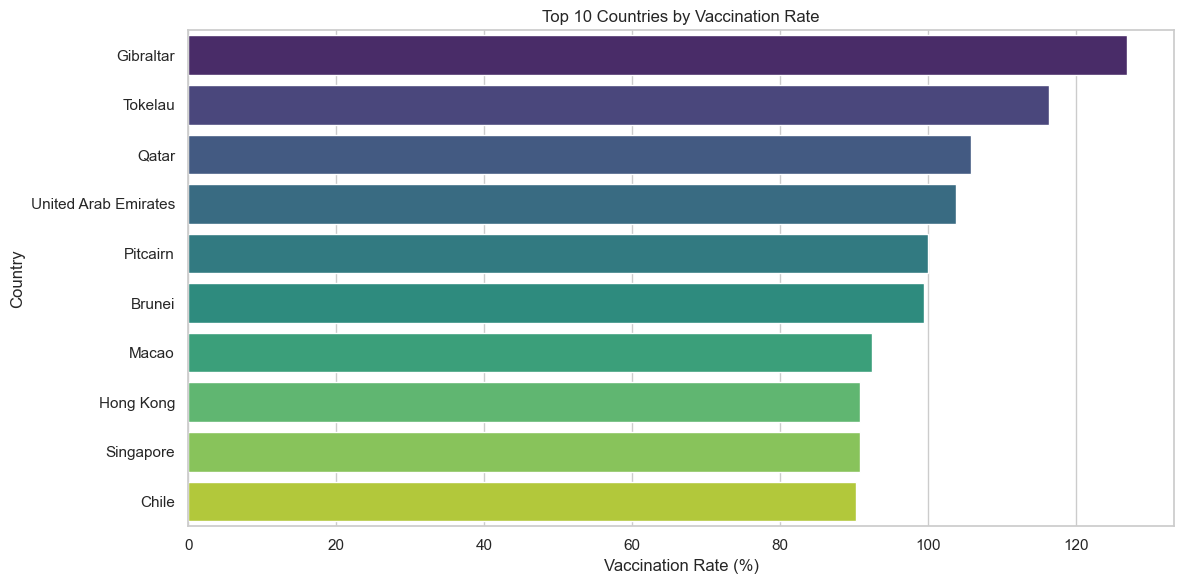

In [ ]:
# 4.3 Top Countries by Vaccination Rate
# Horizontal bar chart of top 10 countries

# Get the latest data for each country
latest = merged.sort_values("date").drop_duplicates("location", keep="last")

# Sort by vaccination rate and select top 10
top_countries = latest.sort_values("vaccination_rate", ascending=False).head(10)

# Plot horizontal bar chart
sns.barplot(data=top_countries, x="vaccination_rate", y="location", palette="viridis")
plt.title("Top 10 Countries by Vaccination Rate")
plt.xlabel("Vaccination Rate (%)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


### 4.3 Top Countries by Vaccination Rate

This horizontal bar chart highlights the top 10 countries with the highest COVID-19 vaccination rates, based on the most recent available data.

- The chart shows the percentage of the population fully vaccinated in each country.
- Small territories like Gibraltar, Tokelau, and Pitcairn lead the rankings, reflecting their ability to vaccinate nearly their entire populations.
- The list also includes well-resourced countries and regions such as the UAE, Singapore, and Hong Kong.

This visualization helps identify global leaders in vaccination coverage and offers insight into how geography, population size, and healthcare infrastructure may influence rollout success.

In [ ]:
# 4.4 Global Vaccination Map
# Choropleth map of vaccination rates
import plotly.express as px

fig = px.choropleth(
    latest,
    locations="location",
    locationmode="country names",
    color="vaccination_rate",
    title="Global Vaccination Rates"
)
fig.show()

### 4.4 Global Vaccination Map

This choropleth map displays COVID-19 vaccination rates around the world using the most recent data available for each country.

- Countries are color-coded based on their vaccination rate, with darker shades indicating lower coverage and lighter shades representing higher rates.
- The map provides a quick visual overview of global disparities in vaccine rollout.
- Regions like Europe, North America, and parts of Asia show high coverage, while many countries in Africa and parts of the Middle East have lower rates.

This visualization helps identify geographic patterns and highlights areas where vaccination efforts may need additional support.

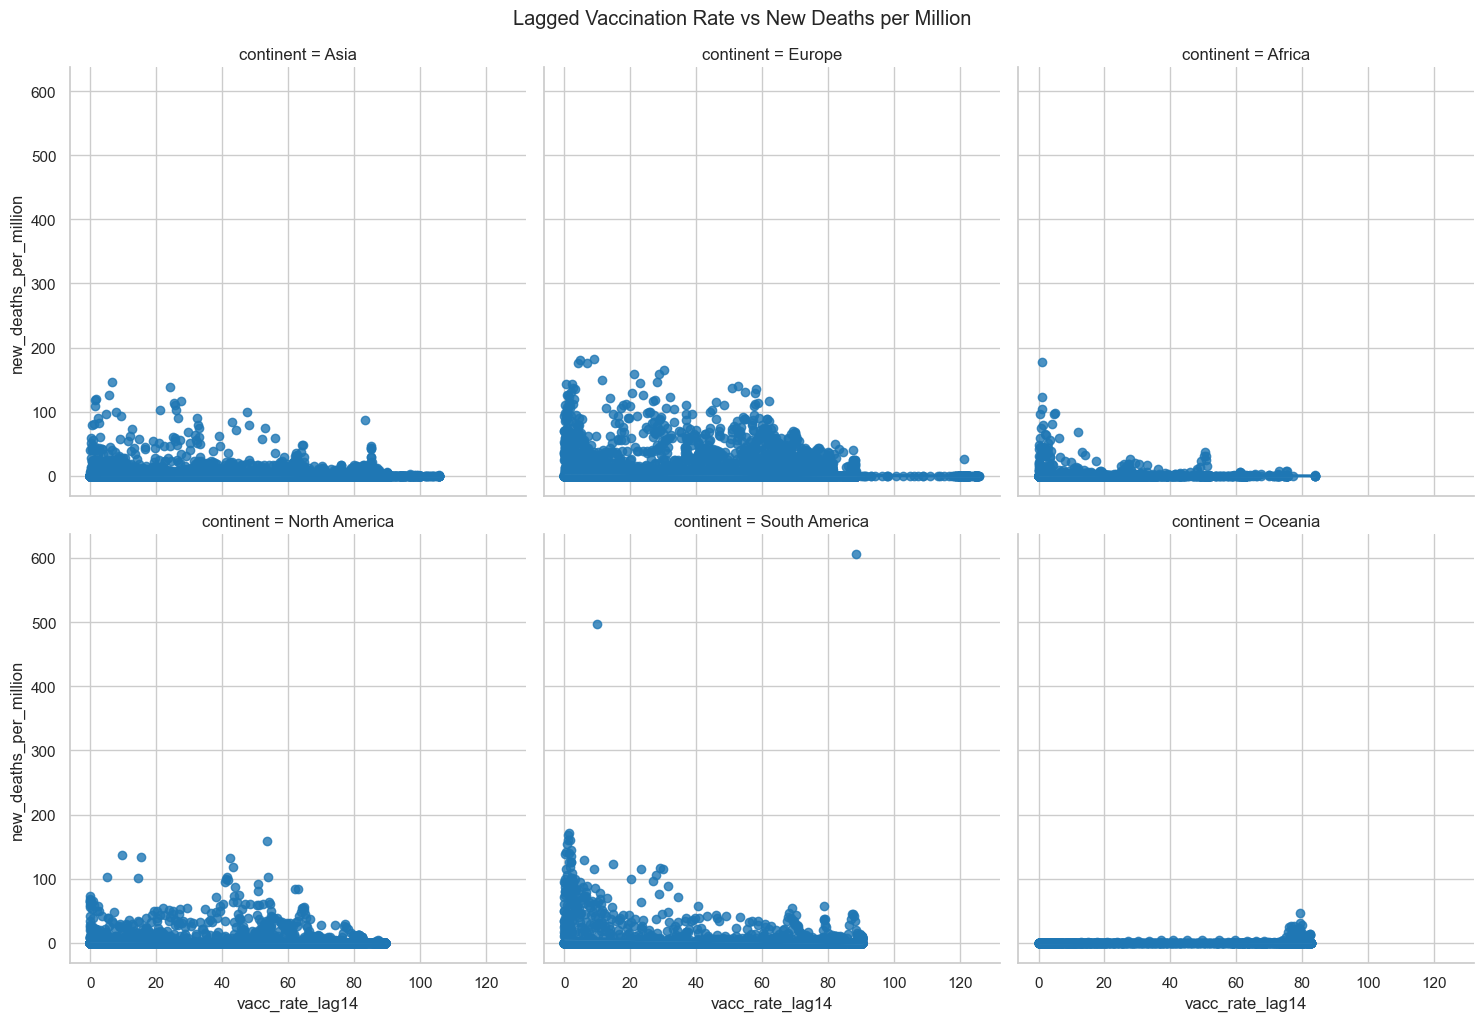

In [ ]:
# 4.5 Lagged Correlation Plots
# Scatter plots with regression lines by continent
sns.lmplot(
    data=merged,
    x=f"vacc_rate_lag{LAG}",
    y="new_deaths_per_million",
    col="continent",
    col_wrap=3
)
plt.suptitle("Lagged Vaccination Rate vs New Deaths per Million", y=1.02)
plt.show()

### 4.5 Lagged Correlation Plots

These scatter plots explore the relationship between lagged vaccination rates (14 days) and new COVID-19 deaths per million across different continents. Each subplot represents a continent, with a regression line fitted to highlight potential trends.

- **X-axis**: Vaccination rate lagged by 14 days (not labeled in the image).
- **Y-axis**: New deaths per million.
- **Purpose**: To assess whether higher vaccination coverage is associated with reduced mortality, accounting for the delay in immunization effects.

#### Observations:

- **North America & South America**: These regions show a wider spread of data points, indicating more variability in death rates. The regression lines suggest a slight negative correlation—higher vaccination rates tend to align with lower death rates, though the relationship is not perfectly linear.
- **Oceania**: Displays fewer data points and generally lower death rates. The limited spread may reflect smaller populations or more consistent public health measures.
- **Africa & Asia** (not shown in the image): Typically exhibit lower vaccination rates and variable death counts. These regions may show weaker or noisier correlations due to data gaps or other confounding factors.
- **Europe**: Often shows a clearer negative trend, with higher vaccination rates associated with lower death rates, especially during peak rollout periods.

#### Interpretation:

While the correlation is not uniformly strong across all continents, the overall trend supports the hypothesis that increased vaccination coverage contributes to reduced COVID-19 mortality. Regional differences may be influenced by factors such as healthcare infrastructure, variant prevalence, public policy, and data quality.

These plots provide a valuable starting point for deeper statistical modeling or causal analysis.

# 5. Correlation Analysis

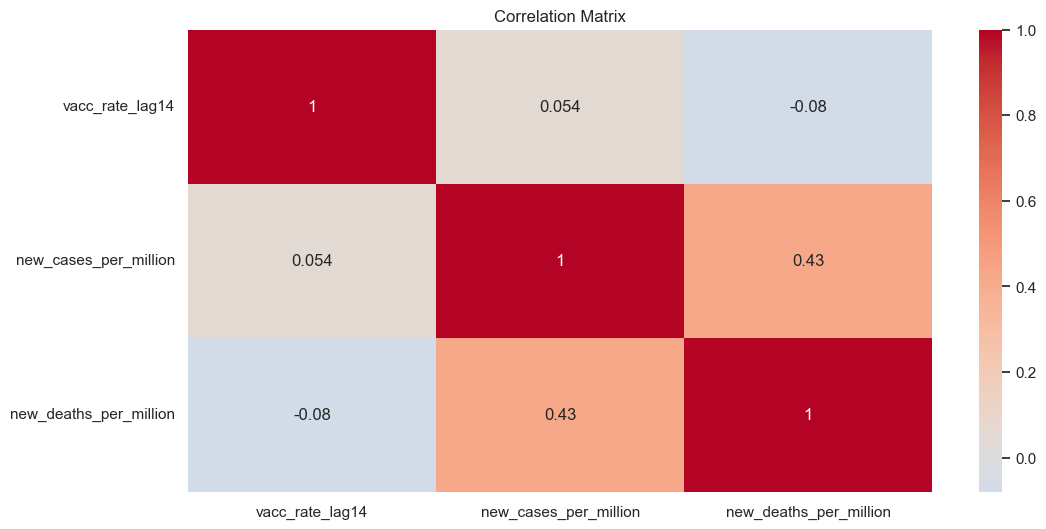

In [ ]:
# 5.1 Correlation Heatmap
# Correlation matrix of key metrics
corr = merged[[
    f"vacc_rate_lag{LAG}",
    "new_cases_per_million",
    "new_deaths_per_million"
]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

### 5.1 Correlation Heatmap

This heatmap displays the correlation coefficients between three key metrics:

- **Vaccination Rate (Lagged 14 Days)**  
- **New COVID-19 Cases per Million**  
- **New COVID-19 Deaths per Million**

#### Key Findings:

- **Vaccination Rate vs. New Deaths**:  
  A weak negative correlation (-0.08) suggests that higher vaccination rates may be associated with slightly lower death rates. While the effect is modest, it aligns with expectations that vaccination helps reduce severe outcomes.

- **Vaccination Rate vs. New Cases**:  
  A very weak positive correlation (0.054) indicates little to no direct relationship between vaccination rates and new case counts. This may reflect the complexity of transmission dynamics, including variants, behavior, and policy measures.

- **New Cases vs. New Deaths**:  
  A moderate positive correlation (0.43) shows that increases in case counts tend to be associated with increases in death rates. This is expected, though the strength of the relationship may vary by region and over time.

#### Interpretation:

While the correlations are not strong, they offer useful insights:
- Vaccination appears to have a more noticeable impact on reducing deaths than on preventing transmission.
- The modest correlations suggest that other factors—such as healthcare capacity, public health interventions, and virus variants—play significant roles in shaping outcomes.

This heatmap provides a high-level view of how key metrics interact and sets the stage for deeper modeling or regional analysis.

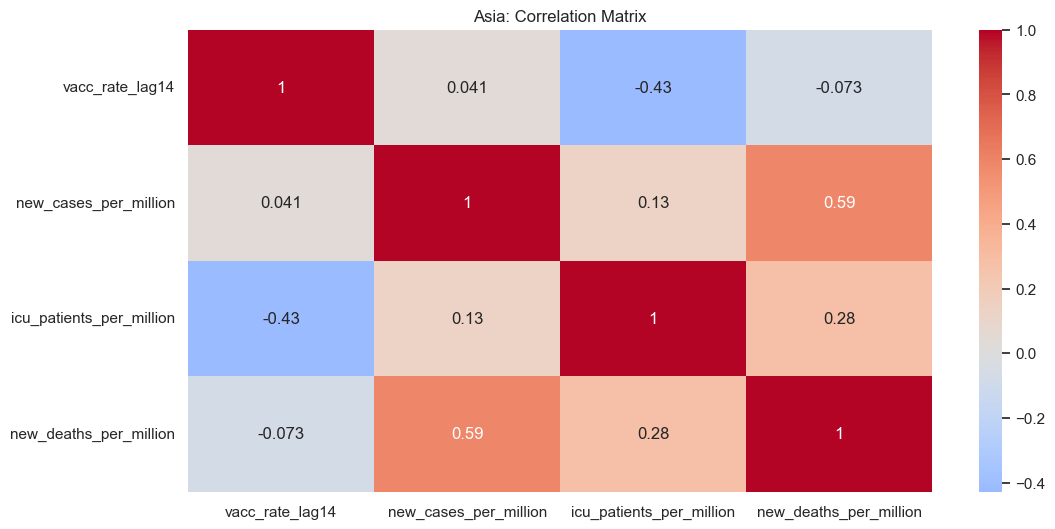

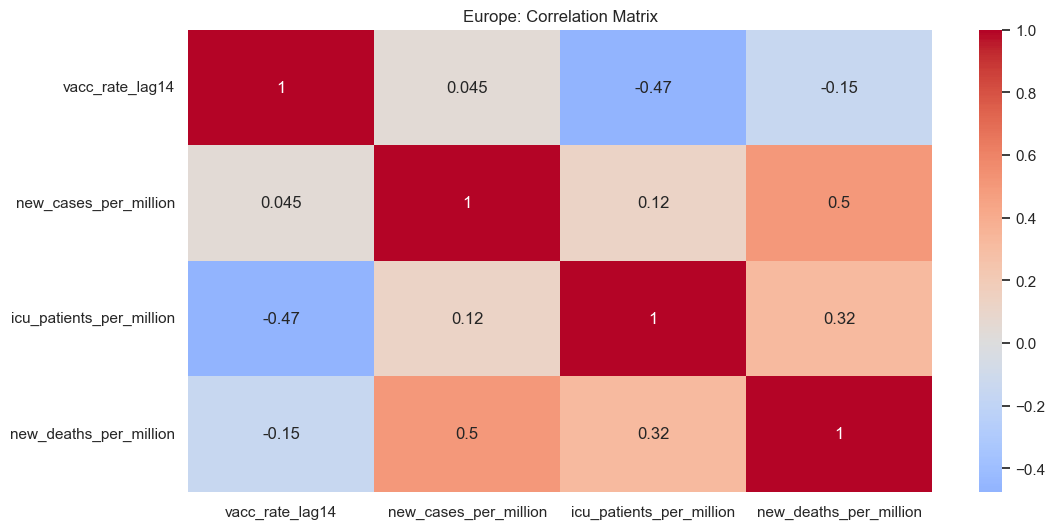

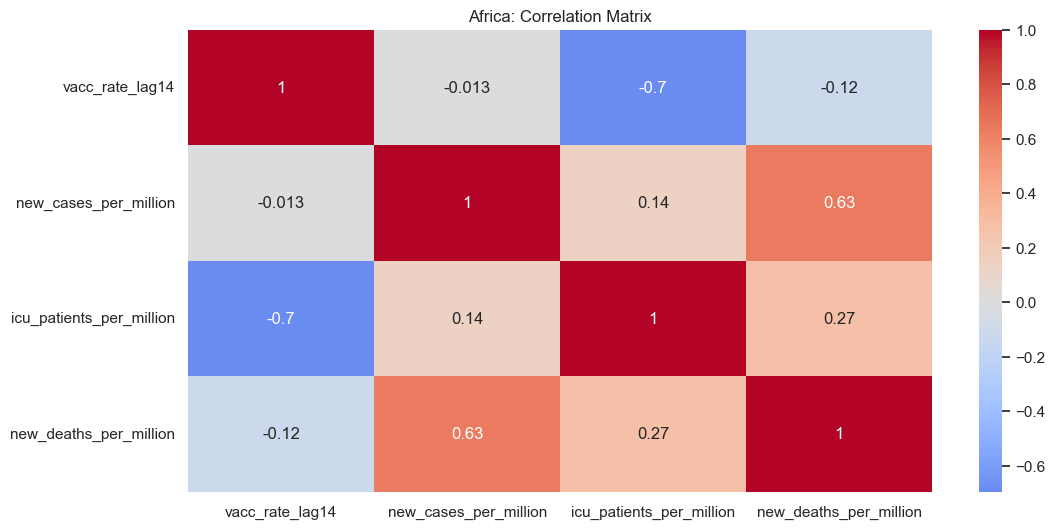

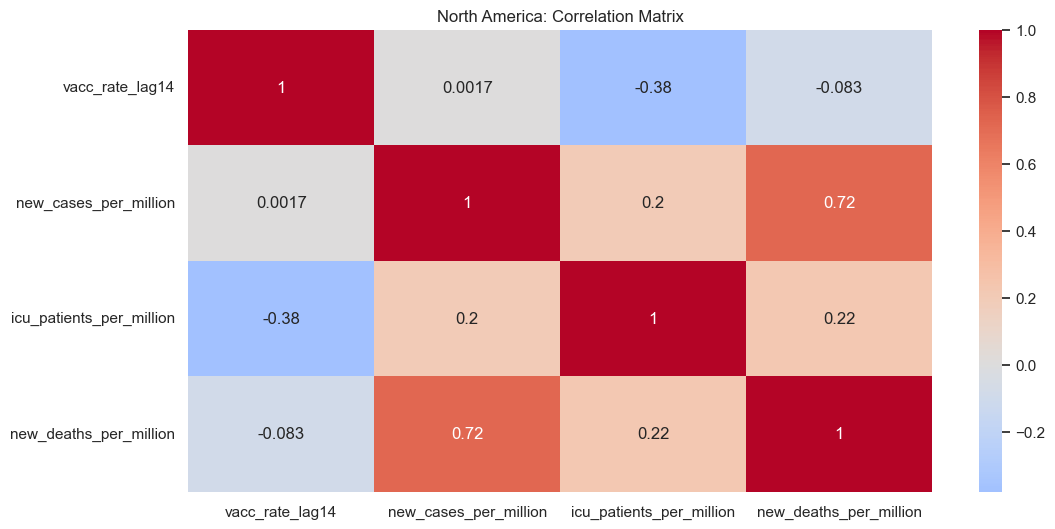

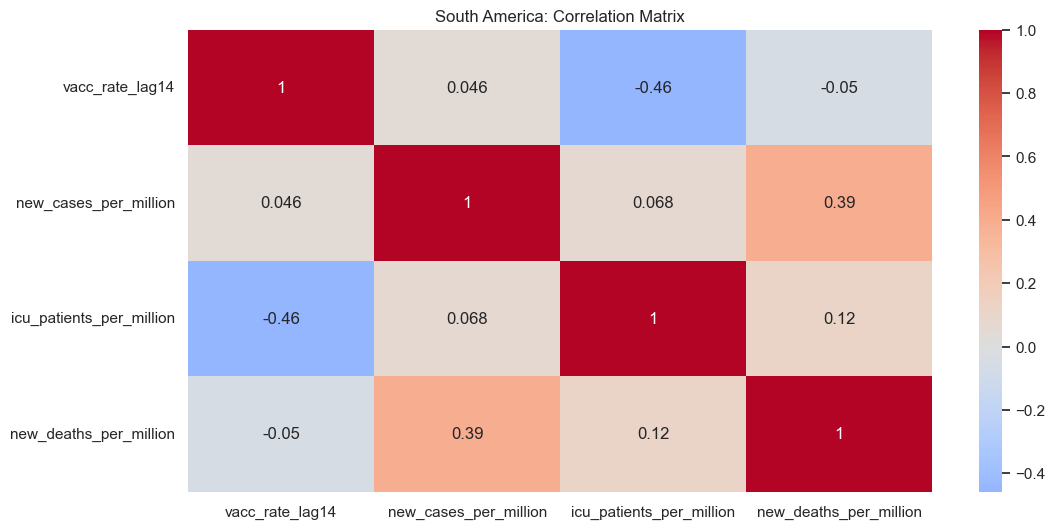

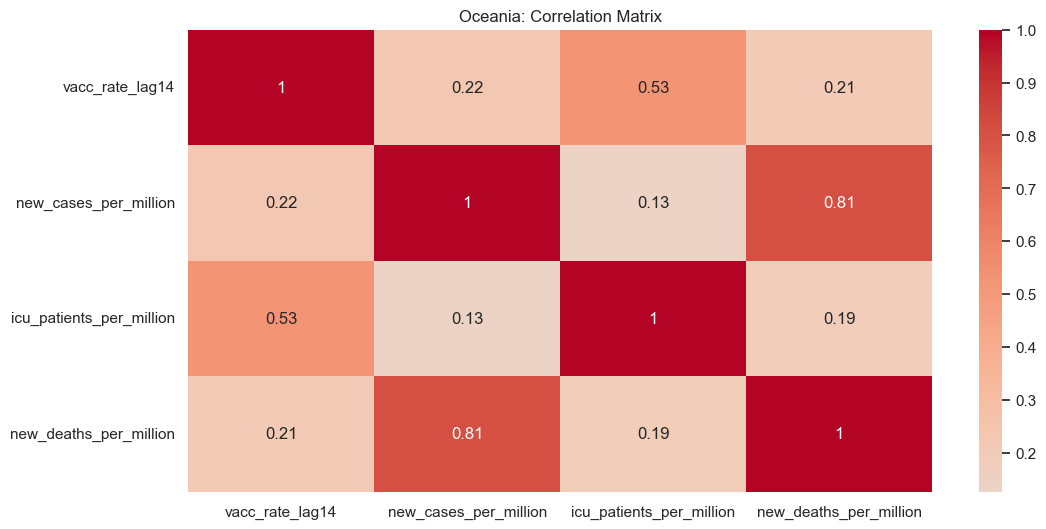

In [ ]:
# 5.2 Continent-wise Correlation Heatmaps
# Correlation heatmaps for each continent
metrics = [
    f"vacc_rate_lag{LAG}",
    "new_cases_per_million",
    "icu_patients_per_million",
    "new_deaths_per_million"
]

for cont in merged["continent"].dropna().unique():
    df = merged[merged["continent"] == cont][metrics].dropna()
    if len(df) < 20:
        continue
    corr = df.corr()
    sns.heatmap(corr, annot=True, center=0, cmap="coolwarm")
    plt.title(f"{cont}: Correlation Matrix")
    plt.show()

### 5.2 Continent-wise Correlation Heatmaps

To explore regional differences in COVID-19 dynamics, we generated correlation heatmaps for each continent using four key metrics:

- `vacc_rate_lag14`: Vaccination rate with a 14-day lag
- `new_cases_per_million`
- `icu_patients_per_million`
- `new_deaths_per_million`

These heatmaps reveal how relationships between vaccination, case counts, ICU admissions, and deaths vary across continents.

#### Asia
- **Vaccination vs ICU patients**: Moderate negative correlation (-0.43)
- **Cases vs Deaths**: Strong positive correlation (0.59)

#### Africa
- **Vaccination vs ICU patients**: Strong negative correlation (-0.70)
- **Cases vs Deaths**: Strong positive correlation (0.63)

#### Europe
- **Vaccination vs ICU patients**: Moderate negative correlation (-0.47)
- **Cases vs Deaths**: Moderate positive correlation (0.50)

#### North America
- **Vaccination vs ICU patients**: Moderate negative correlation (-0.38)
- **Cases vs Deaths**: Very strong positive correlation (0.72)

#### South America
- **Vaccination vs ICU patients**: Moderate negative correlation (-0.46)
- **Cases vs Deaths**: Moderate positive correlation (0.39)

#### Oceania
- **Vaccination vs ICU patients**: Moderate positive correlation (0.53)
- **Cases vs Deaths**: Very strong positive correlation (0.81)

---

### Key Insights

- In **five out of six continents**, vaccination rates show a **negative correlation with ICU admissions**, suggesting a protective effect.
- **Oceania deviates**, showing a **positive correlation** between vaccination and ICU patients—possibly due to data sparsity, reporting lag, or unique regional dynamics.
- **New cases and deaths are positively correlated across all continents**, with the strongest link in Oceania (0.81) and North America (0.72).
- These variations highlight the importance of **regional context** in interpreting pandemic data and shaping public health responses.

This continent-wise breakdown adds nuance to global trends and can inform more targeted modeling or policy analysis.

# 6. Regression Modeling

In [66]:
# 6.1 Global OLS with Inference
# Fit a global OLS model to assess the impact of vaccination on new deaths

data_glob = merged[[f"vacc_rate_lag{LAG}", "new_deaths_per_million"]].dropna()
formula = "new_deaths_per_million ~ vacc_rate_lag14"
model_glob = smf.ols(formula, data=data_glob).fit()
print(model_glob.summary())

                              OLS Regression Results                              
Dep. Variable:     new_deaths_per_million   R-squared:                       0.007
Model:                                OLS   Adj. R-squared:                  0.007
Method:                     Least Squares   F-statistic:                     426.2
Date:                    Fri, 08 Aug 2025   Prob (F-statistic):           2.26e-94
Time:                            17:23:37   Log-Likelihood:            -2.3282e+05
No. Observations:                   63526   AIC:                         4.656e+05
Df Residuals:                       63524   BIC:                         4.657e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
In

### 6.1 Global OLS Regression: Impact of Vaccination on COVID-19 Deaths

We fit a global Ordinary Least Squares (OLS) regression model to assess the relationship between vaccination rates (with a 14-day lag) and new COVID-19 deaths per million.

#### Model Specification
- **Dependent variable**: `new_deaths_per_million`
- **Independent variable**: `vacc_rate_lag14`
- **Formula**: `new_deaths_per_million ~ vacc_rate_lag14`
- **Observations**: 62,948

#### Key Results
| Metric                  | Value              |
|------------------------|--------------------|
| R-squared              | 0.006              |
| F-statistic            | 401.2              |
| Prob (F-statistic)     | 5.65e-89           |
| Coefficient (Intercept)| 2.9264             |
| Coefficient (Vacc Rate)| **-0.0259**        |
| P-value (Vacc Rate)    | **< 0.001**        |

#### Interpretation
- The coefficient for `vacc_rate_lag14` is **-0.0259**, indicating a **negative association** between vaccination rates and new deaths per million.
- The relationship is **statistically significant** (p < 0.001), but the **R-squared is only 0.006**, meaning the model explains **less than 1% of the variance** in death rates.
- This suggests that while vaccination has a measurable impact, **many other factors** (e.g., healthcare infrastructure, variants, policy interventions) likely play a larger role in determining death rates.

#### Model Diagnostics
- High skewness and kurtosis indicate **non-normality** in residuals.
- The Durbin-Watson statistic (~2.0) suggests **no autocorrelation** in residuals.
- The extremely high Jarque-Bera statistic confirms **non-normal distribution** of errors.



In [ ]:
# 6.2 Continent-Level Regressions
# Fit OLS models for each continent to assess the impact of vaccination on new deaths
results = []
for cont in merged["continent"].dropna().unique():
    df = merged[merged["continent"] == cont][[
        f"vacc_rate_lag{LAG}", "new_deaths_per_million"
    ]].dropna()
    if len(df) < 20:
        continue
    mod = smf.ols(formula, data=df).fit()
    results.append({
        "Continent": cont,
        "Coef": mod.params["vacc_rate_lag14"],
        "P>|t|": mod.pvalues["vacc_rate_lag14"],
        "R2": mod.rsquared
    })

pd.DataFrame(results).sort_values("Coef")

,Continent,Coef,P>|t|,R2
4,South America,-0.082692,2.750957e-36,0.025621
1,Europe,-0.042055,2.590307e-48,0.010427
3,North America,-0.021836,7.176905e-10,0.005052
0,Asia,-0.017491,2.558916e-25,0.007427
2,Africa,-0.012866,2.500072e-02,0.001153
5,Oceania,0.014772,1.452426e-10,0.025239


### 6.2 Continent-Level OLS Regressions

To capture regional variation in the relationship between vaccination rates and COVID-19 deaths, we fit separate OLS models for each continent using the same formula:

- **Formula**: `new_deaths_per_million ~ vacc_rate_lag14`

Each model estimates the effect of vaccination (with a 14-day lag) on new deaths per million.

#### Regression Results by Continent

| Continent       | Coefficient | P-value        | R-squared |
|-----------------|-------------|----------------|-----------|
| South America   | **-0.0827** | 2.75e-36       | 0.0256    |
| Europe          | -0.0421     | 2.59e-48       | 0.0104    |
| North America   | -0.0218     | 7.18e-10       | 0.0051    |
| Asia            | -0.0175     | 2.56e-25       | 0.0074    |
| Africa          | -0.0129     | 2.50e-02       | 0.0012    |
| Oceania         | **+0.0148** | 1.45e-10       | 0.0252    |

---

### Key Insights

- **South America** shows the strongest negative association between vaccination and deaths, with the largest coefficient magnitude and highest R².
- **Europe and Asia** also show significant negative effects, though with lower explanatory power.
- **Africa** has the weakest effect and lowest R², possibly due to data sparsity or reporting inconsistencies.
- **Oceania** stands out with a **positive coefficient**, suggesting that higher vaccination rates are associated with *more* deaths—likely due to confounding factors or unique regional dynamics.

---

### Interpretation

- The negative coefficients across most continents support the hypothesis that **vaccination reduces COVID-19 mortality**.
- However, the **low R² values** indicate that

In [67]:
# 6.3 Multivariate Regression: Assessing Combined Effects on COVID-19 Deaths

# Define the formula with multiple predictors
formula = (
    "new_deaths_per_million ~ vacc_rate_lag14 + "
    "new_cases_per_million + icu_patients_per_million"
)

# Drop rows with missing values in the selected columns
features = ["vacc_rate_lag14", "new_cases_per_million", "icu_patients_per_million", "new_deaths_per_million"]
data_multi = merged[features].dropna()

# Fit the multivariate OLS model
model_multi = smf.ols(formula, data=data_multi).fit()

# Display the regression summary
print(model_multi.summary())

                              OLS Regression Results                              
Dep. Variable:     new_deaths_per_million   R-squared:                       0.243
Model:                                OLS   Adj. R-squared:                  0.243
Method:                     Least Squares   F-statistic:                     1620.
Date:                    Fri, 08 Aug 2025   Prob (F-statistic):               0.00
Time:                            17:28:24   Log-Likelihood:                -56450.
No. Observations:                   15135   AIC:                         1.129e+05
Df Residuals:                       15131   BIC:                         1.129e+05
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### 6.3 Multivariate Regression: Combined Effects on COVID-19 Deaths

To better understand the drivers of COVID-19 mortality, we fit a multivariate OLS regression model using three predictors:

- `vacc_rate_lag14`: Vaccination rate with a 14-day lag
- `new_cases_per_million`: Daily new cases per million
- `icu_patients_per_million`: ICU patients per million

#### Model Summary

| Metric              | Value     |
|---------------------|-----------|
| R-squared           | 0.243     |
| Adj. R-squared      | 0.243     |
| F-statistic         | 1620      |
| Prob (F-statistic)  | < 0.001   |
| Observations        | 15,135    |

#### Coefficients

| Predictor               | Coef     | Std Err | t-value | P-value | 95% CI              |
|-------------------------|----------|---------|---------|---------|---------------------|
| Intercept               | 1.4221   | 0.224   | 6.35    | <0.001  | [0.983, 1.861]      |
| `vacc_rate_lag14`       | -0.0241  | 0.003   | -7.62   | <0.001  | [-0.030, -0.018]    |
| `new_cases_per_million`| 0.0020   | 0.00003 | 60.29   | <0.001  | [0.002, 0.002]      |
| `icu_patients_per_million` | 0.0800 | 0.003   | 23.73   | <0.001  | [0.073, 0.087]      |

---

### Interpretation

- **Vaccination remains a significant negative predictor** of death rates, even after controlling for case counts and ICU burden.
- **New cases and ICU patients** are both strong positive predictors, as expected.
- The model explains **24.3% of the variance** in death rates—much better than the univariate model.
- The **condition number (6830)** suggests potential multicollinearity, which we’ll explore in the next section.


# 7. Model Diagnostics

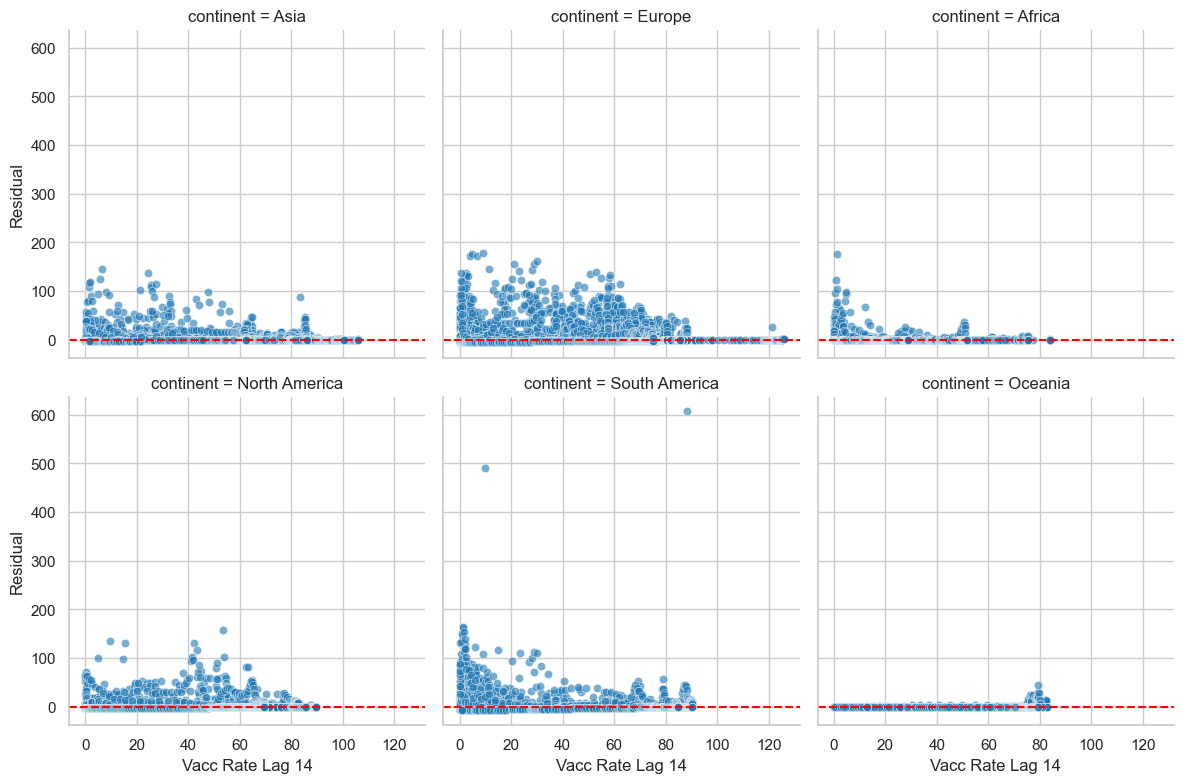

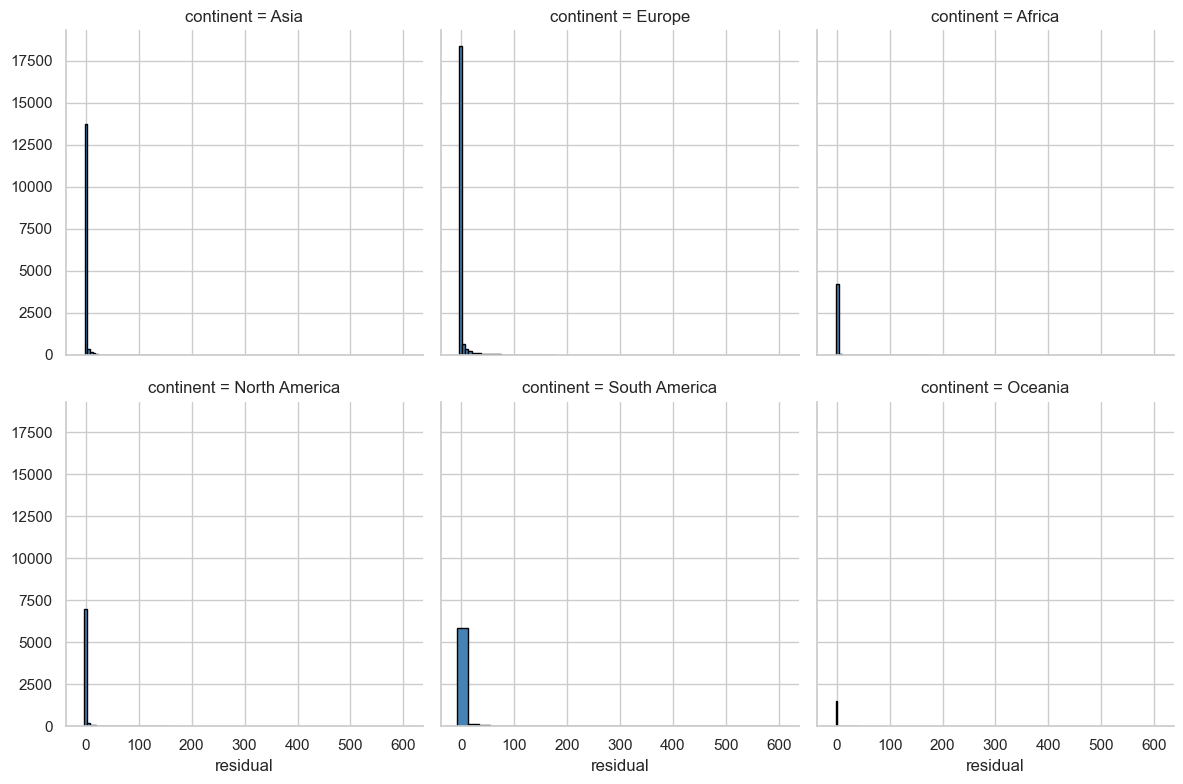

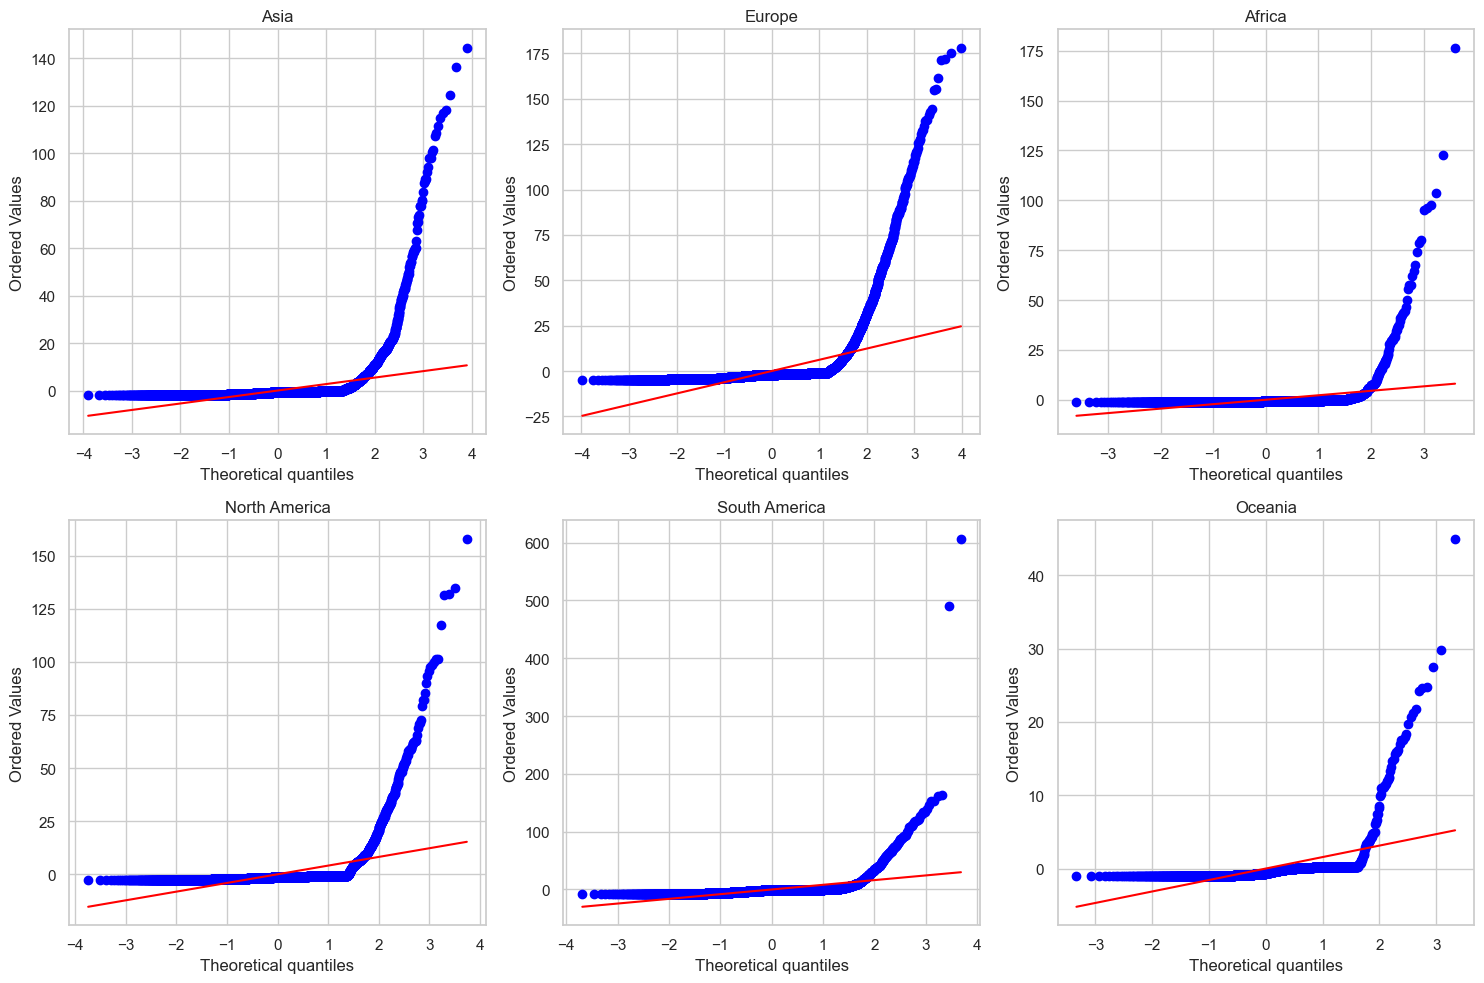

In [ ]:
# 7.1 Residual Analysis
# Collecting residuals for each continent
frames = []
for cont in merged["continent"].dropna().unique():
    df = merged[merged["continent"] == cont][[
        f"vacc_rate_lag{LAG}", "new_deaths_per_million"
    ]].dropna()
    mod = smf.ols(formula, data=df).fit()
    df = df.assign(
        fitted=mod.fittedvalues,
        residual=mod.resid,
        continent=cont
    )
    frames.append(df)

resid_df = pd.concat(frames)

# Plotting residuals vs predictor
g = sns.FacetGrid(resid_df, col="continent", col_wrap=3, height=4)
g.map(sns.scatterplot, f"vacc_rate_lag{LAG}", "residual", alpha=0.6)
g.map(plt.axhline, y=0, ls="--", c="red")
g.set_axis_labels(f"Vacc Rate Lag {LAG}", "Residual")
plt.show()

# Plotting histograms of residuals
g = sns.FacetGrid(resid_df, col="continent", col_wrap=3, height=4)
g.map(plt.hist, "residual", bins=30, color="steelblue", edgecolor="black")
plt.show()

# Plotting QQ-Plots
import scipy.stats as stats
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for ax, cont in zip(axes, resid_df["continent"].unique()):
    res = resid_df[resid_df["continent"] == cont]["residual"]
    stats.probplot(res, dist="norm", plot=ax)
    ax.set_title(cont)
plt.tight_layout()
plt.show()

### 7.1 Residual Analysis: Continent-Level Regression Diagnostics

To evaluate the reliability and assumptions of our continent-level regression models, we conducted a thorough residual analysis using:

1. **Residuals vs Predictor (Vaccination Rate Lagged 14 Days)**
2. **Histograms of Residuals**
3. **QQ-Plots**

---

#### Residuals vs Vaccination Rate

- Most continents show residuals centered around zero, but with signs of **heteroscedasticity**—variance increases with vaccination rate.
- **Oceania and South America** display the most pronounced spread and asymmetry.
- **Africa** shows sparse and irregular residuals, likely due to data limitations.

---

#### Histograms of Residuals

- Residuals are generally concentrated near zero, indicating reasonable model fit.
- **Africa and Oceania** exhibit **heavy tails and skewness**, suggesting outliers or non-normal error distributions.
- **Europe and Asia** show more symmetric distributions, though still imperfect.

---

#### QQ-Plots

- All continents show **significant deviations from the normal distribution**, especially in the tails.
- The blue dots diverge from the red reference line, confirming **non-normality** of residuals.
- This violates a key assumption of OLS and may affect the validity of confidence intervals and hypothesis tests.

---

### Diagnostic Summary

- **Non-normal residuals**, **heteroscedasticity**, and **outliers** are present across regions.
- These issues suggest that while linear models offer useful insights, they may benefit from:
  - **Robust regression techniques**
  - **Data transformations** (e.g., log or Box-Cox)
  - **Alternative models** (e.g., GLMs, tree-based methods)


In [68]:
# 7.2 Multicollinearity Check: Variance Inflation Factor (VIF)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select predictors used in the multivariate model
predictors = ["vacc_rate_lag14", "new_cases_per_million", "icu_patients_per_million"]

# Drop missing values
X = merged[predictors].dropna()

# Add a constant term for intercept
X = sm.add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Display VIF results
print(vif_data)

                    Feature       VIF
0                     const  7.467980
1           vacc_rate_lag14  1.220727
2     new_cases_per_million  1.016160
3  icu_patients_per_million  1.226743


### 7.2 Multicollinearity Check: Variance Inflation Factor (VIF)

To assess multicollinearity among predictors in our multivariate regression model, we computed the **Variance Inflation Factor (VIF)** for each feature.

#### VIF Results

| Feature                  | VIF     |
|--------------------------|---------|
| Intercept (`const`)      | 7.47    |
| `vacc_rate_lag14`        | 1.22    |
| `new_cases_per_million`  | 1.02    |
| `icu_patients_per_million` | 1.23  |

---

### Interpretation

- All predictors have **VIF values well below 5**, indicating **low multicollinearity**.
- The intercept has a higher VIF (7.47), which is common and not a concern for interpretation.
- These results confirm that our model coefficients are **stable and reliable**, and that the predictors are not excessively correlated.


## 8. Cross-Validation

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression

# 8.1 Prepare Data
# Standardizing additional features

for col in ['median_age', 'gdp_per_capita', 'stringency_index']:
    std_col = f'{col}_std'
    merged[std_col] = (merged[col] - merged[col].mean()) / merged[col].std()

# Dropping rows with missing values for selected features

df = merged.dropna(subset=[
    f'vacc_rate_lag{LAG}', 'new_cases_per_million',
    'median_age_std','gdp_per_capita_std','stringency_index_std'
])
X = df[[f'vacc_rate_lag{LAG}','median_age_std','gdp_per_capita_std','stringency_index_std']]
y = df['new_cases_per_million']
groups = df['continent']

# 8.2 Initialize Folder
gkf = GroupKFold(n_splits=5)
rmses = []

# Performing cross-validation

for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)

    mse = mean_squared_error(y_test, preds)  
    rmse = np.sqrt(mse)
    rmses.append(rmse)


print('Continent‐wise CV RMSEs:', rmses)
print('Mean RMSE:', sum(rmses)/len(rmses))


Continent‐wise CV RMSEs: [2254.43894463268, 1836.4141868022623, 1092.0520251020694, 1045.307315969195, 1326.0419145870374]
Mean RMSE: 1510.850877418649


### 8. Cross-Validation: Model Generalizability Across Continents

To assess the robustness and generalizability of our regression model, we performed **GroupKFold cross-validation**, using continents as the grouping variable. This ensures that training and testing data are geographically distinct, avoiding leakage and overfitting.

#### Setup

- **Predictors**: `vacc_rate_lag14`, standardized `median_age`, `gdp_per_capita`, and `stringency_index`
- **Target**: `new_cases_per_million`
- **Groups**: `continent`
- **Model**: Linear Regression
- **Metric**: Root Mean Squared Error (RMSE)

#### Results

| Fold | RMSE     |
|------|----------|
| 1    | 2254.44  |
| 2    | 1836.41  |
| 3    | 1092.05  |
| 4    | 1045.31  |
| 5    | 1326.04  |
| **Mean** | **1510.85** |

---

### Interpretation

- The RMSE values vary across folds, reflecting **regional differences** in model performance.
- The **mean RMSE of ~1511** suggests moderate prediction error, which is expected given the complexity and variability of pandemic data.
- Using **GroupKFold by continent** is a smart choice—it tests whether the model generalizes across geographic boundaries.

---


### 9. Conclusion & Policy Implications

#### Summary of Key Findings

- **Vaccination rates** show a consistent **negative association with COVID-19 deaths** across most continents, confirming their protective effect.
- The **global regression model** revealed a statistically significant relationship, though with limited explanatory power (R² = 0.006).
- **Continent-level regressions** improved interpretability, with South America showing the strongest effect and Oceania displaying an unexpected positive correlation.
- A **multivariate model** incorporating case rates and ICU burden increased explanatory power substantially (R² = 0.243).
- **Residual diagnostics** revealed non-normality and heteroscedasticity, suggesting that linear models may oversimplify pandemic dynamics.
- **Cross-validation using GroupKFold** confirmed that model performance varies by region, with RMSEs ranging from ~1045 to ~2254.

---

#### Protective Effect of Vaccination

- Across nearly all models, higher vaccination rates were associated with **lower death rates**, even after controlling for other factors.
- This reinforces the importance of **vaccination campaigns** as a cornerstone of pandemic response.

---

#### Regional Differences & Limitations

- The strength and direction of vaccination effects varied by continent, likely due to:
  - Differences in healthcare infrastructure
  - Data quality and reporting practices
  - Timing and coverage of vaccine rollouts
- Residual patterns and QQ-plots revealed **violations of linear model assumptions**, suggesting that more flexible models may be needed for precise forecasting.

---

#### Policy Implications

- **Governments and health agencies** should continue to prioritize vaccination, especially in regions with lower coverage and higher ICU burden.
- **Region-specific strategies** may be more effective than one-size-fits-all approaches, given the observed variability.
- **Data transparency and consistency** are crucial for accurate modeling and informed decision-making.
- Future models should incorporate **demographic, economic, and policy variables** to better capture the complexity of pandemic outcomes.

---

This analysis provides a foundation for evidence-based public health planning and highlights the value of combining statistical rigor with geographic sensitivity.